In [ ]:
# how to install a package you don't already have installed (remove # from the code below to run)

# import sys
# !{sys.executable} -m pip install NAME_OF_PACKAGE


In [43]:
# numerical analysis
import numpy as np
import pandas as pd

# visualisation
from matplotlib import pyplot as plt

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


Our dataset is the famous Titanic dataset. Very popular in machine learning because its quite easy to explain what the underlying story is. It is a dataset of survival of Titanic passengers and some background details on them.

Note: this is just intended as a basic overview of the techniques for the first class. In subsequent classes we will make this exploration more detailed.

Important: for time management purposes I have split this in two parts. The first part is the data cleaning part. As you know, a vital part of data science and ML - probably the most important part. I have given you the raw data to run this code yourself, but I want you to start in the class at Part 2, using the datafile 'Class1.csv'

## Part 1: 

## We will skip this part in the class, but you can run it yourself in your own time. For this part, you would use the dataset 'Class1_original.csv'. I'll briefly talk through this code, but we will start at Part 2, which uses the cleaned dataset 'Class1.csv'

In [13]:
# Import data which is in two different datasets - a training dataset and a testing one.

titanic = pd.read_csv("Class1_original.csv")

In [ ]:
titanic.head()

In [ ]:
# Dataset info

titanic.info()

Let's clean up the dataset first before testing. I'm following some of the excellent guide from here: https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [ ]:
# Drop cabin variable as too much missing data and too unique

titanic = titanic.drop(["Cabin"], axis=1)

# Drop PassengerID and ticket as too unique

titanic = titanic.drop(["PassengerId", "Ticket"], axis=1)

# Parch somewhat duplicates sibsp
#   sipsp: number of siblings / spouses aboard the Titanic
#   parch: number of parents / children aboard the Titanic

titanic = titanic.drop(["Parch"], axis=1)

titanic.head()

In [ ]:
# Let's try to get value from the name variable
#    Have a look up 'regex' if you are unsure about the (' ([A-Za-z]+)\.', expand=False) part of the code

titanic['Title'] = titanic.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(titanic['Title'], titanic['Sex'])

In [ ]:
# contd.

titanic['Title'] = titanic['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

titanic['Title'] = titanic['Title'].replace('Mlle', 'Miss')
titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')
    
titanic[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

In [ ]:
# contd

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

titanic['Title'] = titanic['Title'].map(title_mapping)
titanic['Title'] = titanic['Title'].fillna(0)

titanic = titanic.drop(["Name"], axis=1)

titanic.head()

In [ ]:
# Convert categories to numerical

titanic['Sex'] = titanic['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

titanic['Embarked'] = titanic['Embarked'].fillna('S') # 'S' is the most frequent port
titanic['Embarked'] = titanic['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

titanic.head()

In [21]:
# And now something really messy with age, as we have a few missing data points, but don't want to drop the rows

guess_ages = np.zeros((2,3))

for i in range(0, 2):
    for j in range(0, 3):
        guess_df = titanic[(titanic['Sex'] == i) & \
                                (titanic['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

        age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
for i in range(0, 2):
    for j in range(0, 3):
        titanic.loc[ (titanic.Age.isnull()) & (titanic.Sex == i) & (titanic.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

titanic['Age'] = titanic['Age'].astype(int)


In [ ]:
# What does the data look like now

titanic.head()

In [ ]:
# Check theres no more missing data

titanic.info()

In [24]:
# save the dataset (this is what becomes the file 'Class1.csv')
# if you have run the code from the original dataset you don't need to do this, but its always useful to save your work

titanic.to_csv('Class1.csv')

## Part 2: This is the part that we will start the live class. If you have been following the code through from the original dataset then you would skip the next codebox and continue with the rest of the code as normal.

In [ ]:
# skip if you are continuing the code from the beginning, but it doesn't really make a difference

titanic = pd.read_csv("Class1.csv")

titanic.head()

In [ ]:
# there seems to be an extra column (a copy of the index) there called 'Unnamed: 0', lets drop that

titanic = titanic.drop(["Unnamed: 0"], axis=1)

# doublecheck the loaded file now has the same data as the original file

titanic.info()

# yes it does, we are good to go...

In [ ]:
# Naive expectation
#   What is our survival expectation without any knowledge

print(titanic["Survived"].describe())

# in the dataset 1 is survived and 0 is deceased. In our dataset 38% of the population survived
# So our naive expectation is that a model with no knowledge would predict that everyone died, and be 62% accurate

# See the video from Alan Chalk on Moodle Week 1 where he explains the difference between naive and baseline models

In [ ]:
# Specify testing variables (following standard regression notation format: y = a + bX)

X = titanic.drop("Survived", axis=1)
y = titanic["Survived"]

# Create a testing and a training dataset (random state can be any number, but has to be there for reproducibility)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
# Logistic regression machine learning

# 1. State the model you want to use
lr = LogisticRegression(max_iter=200, random_state=42)

# 2. Put training data in model
lr.fit(X_train, y_train)

# 3. Check model works on test data
y_pred = lr.predict(X_test)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

# Note: accuracy is significantly higher than the naive accuracy

In [ ]:
# Inspect

coeff_df = pd.DataFrame(titanic.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(lr.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

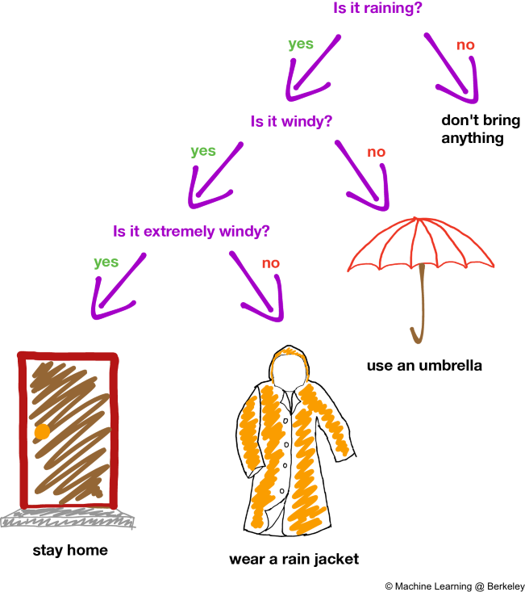

In [16]:
## Decision Trees: what are they?

# DON'T run this codebox or the image will disappear. It's hosted on my own computer

Image(filename = "decision.png", width = 600, height = 300)

In [ ]:
# Decision Tree

# Note how the code structure is almost the same as logistic regression. This simplicity is why Python is so popular 

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

In [ ]:
# See the decision tree

plt.figure(figsize=(12,12))
plot_tree(dt, max_depth=2, fontsize=10, feature_names=X_train.columns) 
plt.show()

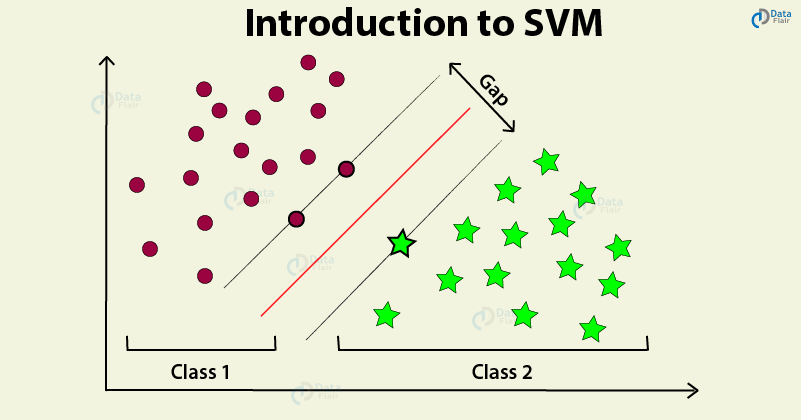

In [19]:
## Support Vector Machines

# DON'T run this codebox or the image will disappear. It's hosted on my own computer

Image(filename = "svm.png", width = 600, height = 300)

In [ ]:
# Support vector machines

svc = SVC(random_state=42)

svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

# we'll explore why this underperformance has occurred in future classes, and how to improve it

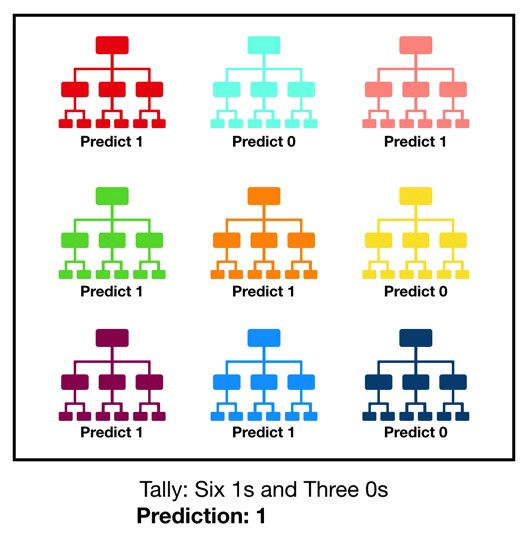

In [21]:
## Random Forests

# DON'T run this codebox or the image will disappear. It's hosted on my own computer

Image(filename = "forest.jpeg", width = 600, height = 300)

In [ ]:
# Random Forests

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

In [ ]:
# Gradient Boosting

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

gb.score(X_train, y_train)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)


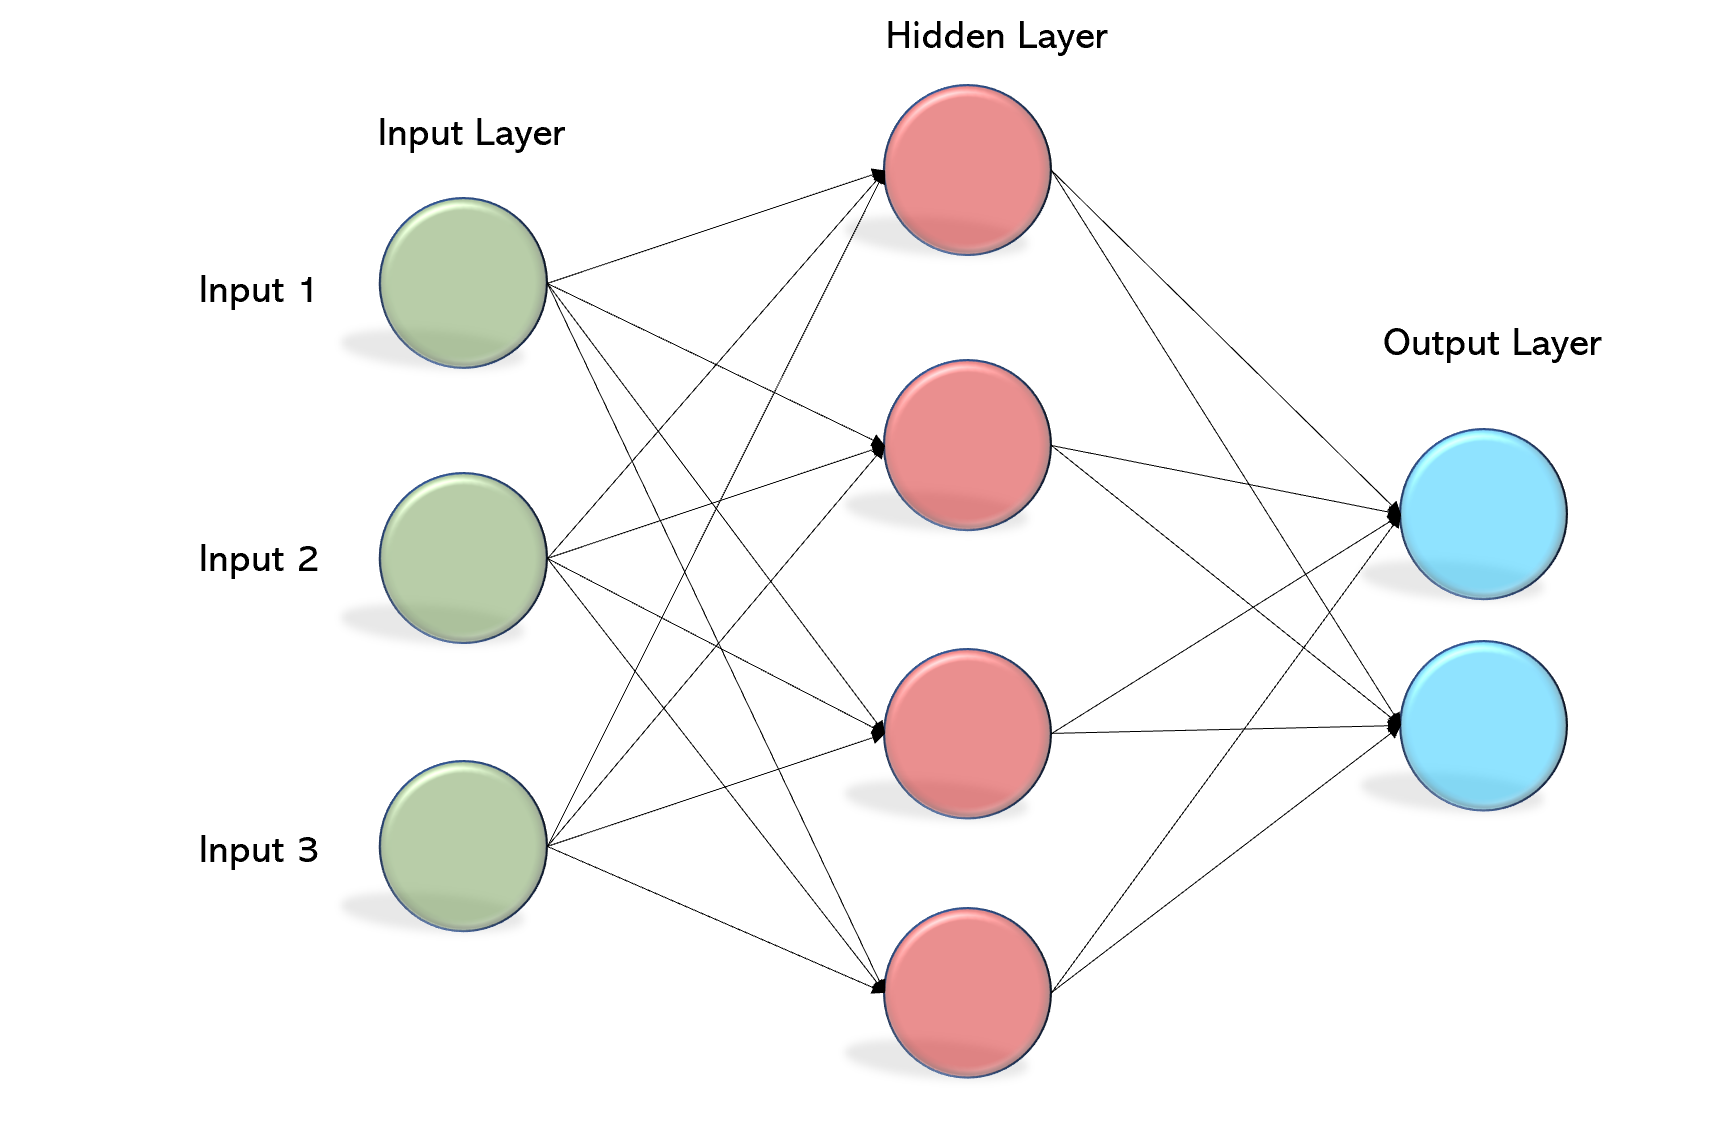

In [24]:
## Deep learning

# DON'T run this codebox or the image will disappear. It's hosted on my own computer

Image(filename = "deep.png", width = 600, height = 300)

In [ ]:
# Multilayer Perceptron (neural network)

mlp = MLPClassifier(hidden_layer_sizes=(6,5,4),max_iter=500, random_state=42)

mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)


In [ ]:
# A bit more on accuracy

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
gb.score(X_train, y_train)
print(classification_report(y_test,y_pred))

# explanation: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

What if we have a continuous variable as outcome, not 1,0, then can use:

- LinearRegression instead of LogisticRegression
- SVR instead of SVC
- DecisionTreeRegressor instead of DecisionTreeClassifier
- RandomForestRegressor instead of RandomForestClassifier
- GradientBoostingRegressor instead of GradientBoostingClassifier

Remember to import them in order to be able to use them